<a href="https://colab.research.google.com/github/xxziris/BS6207/blob/main/BS6207_Assignment3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BS6207 Assignment3

Given a 32x32 pixels, 3 channels input. Fill the pixel values with torch.randn( . . . )
For each pytorch functions in the list,
1. Initialise the weights with uniform random numbers r
2. Call the functions and get the output tensors - `torch_out`
3. Implement these functions from scratch, without using
any neural network libraries. Use linear algebra libraries
in python is ok. Output your tensors as — `my_out`
4. Compare and show that torch_out and my_out are equal
up to small numerical errors



In [1]:
import torch
import torch.nn as nn
import torchvision.ops 
import numpy as np
import random

In [2]:
# generate input as required
torch.manual_seed(7)

input = torch.randn(1, 3, 32, 32, requires_grad = False)
input.shape

torch.Size([1, 3, 32, 32])

In [3]:
# convert tensor input to np array
input_np = input.detach().numpy()

## 1. MaxPool2d

torch.nn.MaxPool2d(kernel_size=2, stride=1, padding=0,
dilation=1, return_indices=False, ceil_mode=False)

In [4]:
# implement the neural network in pytorch
maxpool = nn.MaxPool2d(kernel_size = 2, stride = 1, padding = 0, dilation = 1, return_indices = False, ceil_mode = False)
output_max = maxpool(input)

In [5]:
# print output
output_max.shape

torch.Size([1, 3, 31, 31])

In [6]:
# implement MaxPool2d from scrach with no padding and kernel_size = 2
def MaxPool2d_scrach(input, stride, dilation):
  _,x,y,z = input.shape
  output = np.zeros(shape = (1,3,31,31))
  # loop through the 3 channels
  for i in range(x):
    # for each channel, apply kernel 2x2 with dilation of 1
    temp = input[0][i]
    loc_lim_y = (y - dilation * 1) // stride # number of kernels per row
    loc_lim_z = (z - dilation * 1) // stride # number of kernels per column
    # apply kernel from left to right, top to bottom
    for k in range(0, loc_lim_y, stride): 
      v = []
      for l in range(0, loc_lim_z, stride):
        lst = [temp[k][l], temp[k + dilation][l], temp[k][l + dilation], temp[k + dilation][l + dilation]]
        v.append(max(lst))
      output[0][i][k] = v
  return output



In [7]:
output_max_scratch = MaxPool2d_scrach(input_np, 1, 1)

In [8]:
# check if the two ouputs are the same (with acceptible level of numerical errors of 1e-4)
(np.absolute(np.subtract(np.round(output_max_scratch,4), output_max.detach().numpy())) < 0.0001).all()

True

## 2. AvgPool2d
torch.nn.AvgPool2d(kernel_size=2, stride=1, padding=0,
ceil_mode=False, count_include_pad=True,
divisor_override=None)

In [9]:
# implement the neural network in pytorch
avgpool = nn.AvgPool2d(kernel_size = 2, stride = 1, padding = 0, count_include_pad = True, 
                       ceil_mode = False, divisor_override = None)
output_avg = avgpool(input)

In [10]:
output_avg.shape

torch.Size([1, 3, 31, 31])

In [11]:
# implement AvgPool2d from scrach with no padding and kernel_size = 2
def AvgPool2d_scrach(input, stride, dilation):
  _,x,y,z = input.shape
  output = np.zeros(shape = (1,3,31,31))
  # loop through the 3 channels
  for i in range(x):
    # for each channel, apply kernel 2x2 with dilation of 1
    temp = input[0][i]
    loc_lim_y = (y - dilation * 1) // stride # number of kernels per row
    loc_lim_z = (z - dilation * 1) // stride # number of kernels per column
    # apply kernel from left to right, top to bottom
    for k in range(0, loc_lim_y, stride): 
      v = []
      for l in range(0, loc_lim_z, stride):
        lst = [temp[k][l], temp[k + dilation][l], temp[k][l + dilation], temp[k + dilation][l + dilation]]
        v.append(sum(lst) / len(lst))
      output[0][i][k] = v
  return output

In [12]:
output_avg_scratch = AvgPool2d_scrach(input_np, 1, 1)

In [13]:
# check if the two ouputs are the same (with acceptible level of numerical errors of 1e-4)
(np.absolute(np.subtract(np.round(output_avg_scratch,4), output_avg.detach().numpy())) < 0.0001).all()

True

## 3. Conv2d (I)
torch.nn.Conv2d(in_channels=3, out_channels=6,
kernel_size=3, stride=1, padding=0, dilation=1, groups=1,
bias=True, padding_mode='zeros')

In [14]:
# implement the conv2d in pytorch
conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=2, stride=1, padding=0, 
                    dilation=1, groups=1, bias=True, padding_mode='zeros')
torch.manual_seed(127)
nn.init.uniform_(conv1.weight) # initialize weight
nn.init.uniform_(conv1.bias) # initialize bias
output_conv1 = conv1(input)
output_conv1.shape

torch.Size([1, 6, 31, 31])

In [15]:
conv1.weight.shape # output_channel, input_channel, kernel_size[0], kernel_size[1]

torch.Size([6, 3, 2, 2])

In [16]:
# implement Conv2d from scratch (3 channels to 6 channels without padding)
from scipy import signal
def Conv2d_scratch(input, out_chennel, kernel_size, stride, dilation, padding, weight, bias):
  # convert weight and bias to np array
  weight = weight.detach().numpy()
  bias = bias.detach().numpy()
  # set the output dimension
  _,x,y,z = input.shape
  out_y = (y - dilation * (kernel_size - 1) - 1) //stride + 1
  out_z = (z - dilation * (kernel_size - 1) - 1) //stride + 1
  output = np.zeros(shape = (1, out_chennel, out_y, out_z))
  # add padding to original input
  temp = input[0]
  if padding > 0:
    temp_new = np.zeros(shape = (x, y + 2* padding, z + 2 * padding))
    for i in range(x):
      temp_new[x] = np.pad(temp[x], ((padding, padding), (padding, padding)))
    temp = temp_new
  # loop through each weight
  w_a, w_b, _, _, = weight.shape
  for a in range(w_a):
    temp_w = weight[a]
    for k in range(0, (y - dilation * (kernel_size - 1)), stride):
      for l in range(0, (z - dilation * (kernel_size - 1)), stride):
        temp_i = temp[...,k:(k + dilation * (kernel_size - 1) + 1):dilation, l:(l + dilation * (kernel_size - 1) + 1):dilation]
        #print(k, (k + dilation * (kernel_size - 1)))
        v = []
        for b in range(w_b):
          v.append(signal.correlate2d(temp_w[b], temp_i[b], mode = 'valid'))
        v = np.add(np.sum(v), bias[a])
        output[0][a][k // stride][l // stride] = v
  return output

In [17]:
output_conv1_scratch = Conv2d_scratch(input_np, 6, 2, 1, 1, 0, conv1.weight, conv1.bias)

In [18]:
# check if the two ouputs are the same (with acceptible level of numerical errors of 1e-4)
(np.absolute(np.subtract(np.round(output_conv1_scratch,4), output_conv1.detach().numpy())) < 0.0001).all()

True

## 4. Conv2d (II)
torch.nn.Conv2d(in_channels=3, out_channels=6,
kernel_size=5, stride=2, padding=0, dilation=2, groups=1,
bias=True, padding_mode='zeros')

In [19]:
# implement the conv2d in pytorch
conv2 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=2, padding=0, 
                    dilation=2, groups=1, bias=True, padding_mode='zeros')
torch.manual_seed(127)
nn.init.uniform_(conv2.weight)
output_conv2 = conv2(input)
output_conv2.shape

torch.Size([1, 6, 12, 12])

In [20]:
# the function is the same as section 3 with different parameters
# get the output
output_conv2_scratch = Conv2d_scratch(input_np, 6, 5, 2, 2, 0, conv2.weight, conv2.bias)

In [21]:
# check if the two ouputs are the same (with acceptible level of numerical errors of 1e-4)
(np.absolute(np.subtract(np.round(output_conv2_scratch,4), output_conv2.detach().numpy())) < 0.0001).all()

True

## 5. ConvTranspose2d
torch.nn.ConvTranspose2d(in_channels=3, out_channels=4,
kernel_size=3, stride=1, padding=0, output_padding=0,
groups=1, bias=True, dilation=1, padding_mode='zeros')

In [22]:
# implement the convTranspose2d in pytorch
conv_trans = nn.ConvTranspose2d(in_channels=3, out_channels=4, kernel_size=3, stride=1, padding=0, output_padding=0, 
                           groups=1, bias=True, dilation=1, padding_mode='zeros')
torch.manual_seed(127)
nn.init.uniform_(conv_trans.weight)
nn.init.uniform_(conv_trans.bias)
output_convtrans = conv_trans(input)
output_convtrans.shape

torch.Size([1, 4, 34, 34])

In [23]:
conv_trans.weight.shape # input_channel, output_channel, kernel_size[0], kernel_size[1]

torch.Size([3, 4, 3, 3])

Transpose convolutional layers are used to upscale the input (i.e. output is larger than input).

The algorithm can be explained by the figure below [1]: 

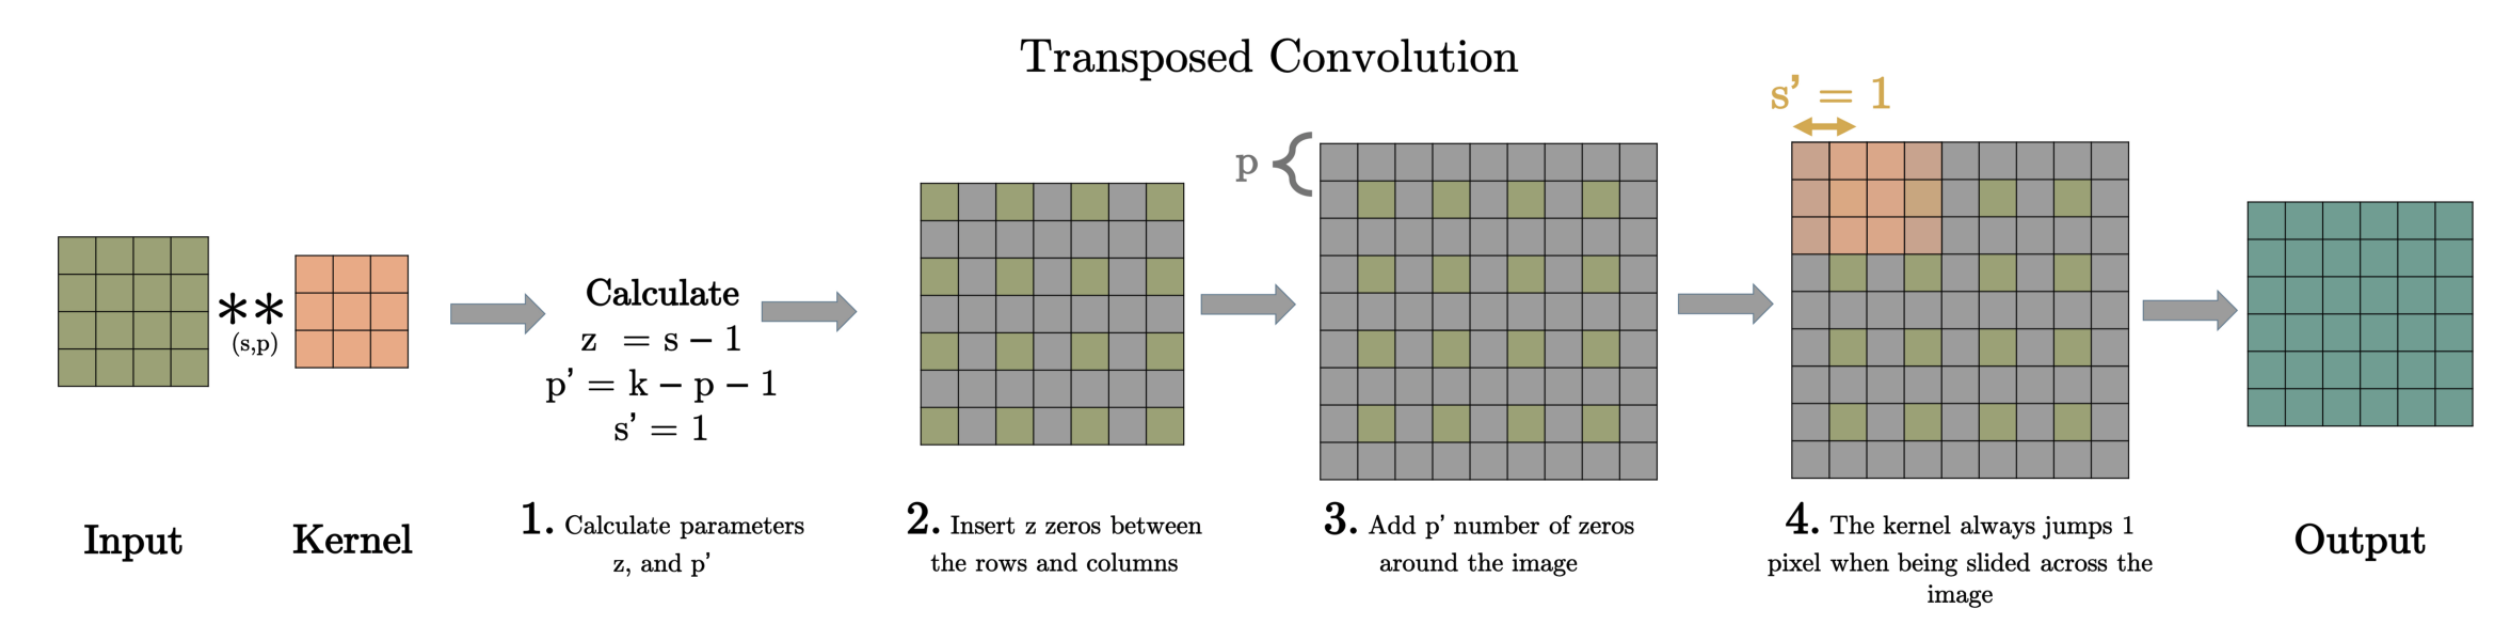

In step 4, instead of applying the kernel directly, the kernel is transformed as illustrated below before multiply with the input [2], where pixels with the same color are multiplied together:

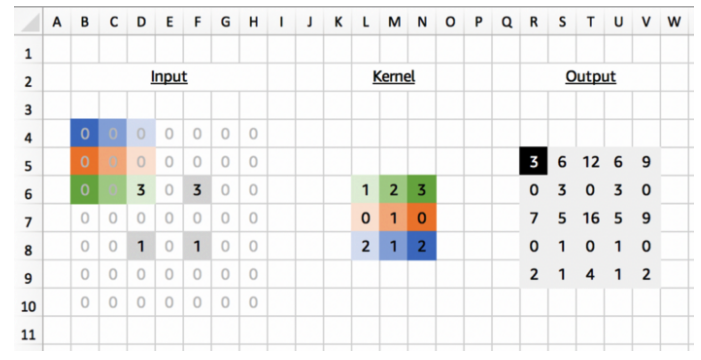




In [24]:
# implement ConvTranspose2d from scratch (3 channels to 4 channels without padding/output_padding)
from scipy import signal
def ConvTrans2d_scratch(input, out_chennel, kernel_size, stride, dilation, padding, weight, bias):
  # convert weight and bias to np array
  weight = weight.detach().numpy()
  bias = bias.detach().numpy()  
  temp = input[0]
  x,y,z = temp.shape
  
  # add padding to original input
  p_pr = kernel_size - padding - 1
  if p_pr > 0:
    temp_new = np.zeros(shape = (x, y + 2 * p_pr, z + 2 * p_pr))
    for i in range(x):
      temp_new[i] = np.pad(temp[i], ((p_pr, p_pr,), (p_pr, p_pr)))
    temp = temp_new

  # set the output dimension
  out_y = (y + 2 * p_pr - dilation * (kernel_size - 1) - 1) //stride + 1
  out_z = (z + 2 * p_pr - dilation * (kernel_size - 1) - 1) //stride + 1
  output = np.zeros(shape = (1, out_chennel, out_y, out_z))

  # loop through each weight
  w_a, w_b, _, _, = weight.shape
  for b in range(w_b):
    temp_w = weight[:,b,:,:]
    for k in range(0, (y + 2 * p_pr - 1 * (kernel_size - 1)), 1):
      for l in range(0, (z + 2 * p_pr - 1 * (kernel_size - 1)), 1):
        temp_i = temp[:,k:(k + 1 * (kernel_size - 1) + 1), l:(l + 1 * (kernel_size - 1) + 1)]
        #print(temp_i.shape)
        v = []
        for a in range(w_a):
          s = 0
          for n in range(kernel_size):
            for m in range(kernel_size):
              s += temp_i[a][n][m] * temp_w[a][kernel_size - n - 1][kernel_size - m - 1]
          v.append(s)
        v = np.sum(v) + bias[b]
        # print(v,b,k,l)
        output[0][b][k][l] = v
  return output

In [25]:
output_convtrans_scratch = ConvTrans2d_scratch(input_np, 4, 3, 1, 1, 0, conv_trans.weight, conv_trans.bias)

In [26]:
# check if the two ouputs are the same (with acceptible level of numerical errors of 1e-4)
(np.absolute(np.subtract(np.round(output_convtrans_scratch,4), output_convtrans.detach().numpy())) < 0.0001).all()

True

## 6. Flatten
torch.flatten(input, start_dim=0, end_dim=-1)

In [27]:
# implement the convTranspose2d in pytorch
output_flat = torch.flatten(input, start_dim = 0, end_dim = -1)

output_flat.shape

torch.Size([3072])

In [28]:
def Flatten_scratch(input):
  _,x,y,z = input.shape
  output = []
  for i in range(x):
    for j in range(y):
      for k in range(z):
        output.append(input[0,i,j,k])
  return np.asarray(output)

In [29]:
output_flat_scratch = Flatten_scratch(input_np)

In [30]:
# check if the two ouputs are the same (with acceptible level of numerical errors of 1e-4)
(np.absolute(np.subtract(np.round(output_flat_scratch,4), output_flat.detach().numpy())) < 0.0001).all()

True

## 7. Sigmoid
torch.sigmoid(input, *, out=None)

In [31]:
# implement the convTranspose2d in pytorch
output_sig = torch.sigmoid(input, out = None)

output_sig.shape

torch.Size([1, 3, 32, 32])

In [32]:
# implement sigmoid function from scratch
import math
def sigmoid_scratch(input):
  _, x, y, z = input.shape
  output = np.zeros(shape = (1, x, y, z))
  for i in range(x):
    for k in range(y):
      for l in range(z):
        output[0][i][k][l] = 1 / (1 + math.exp(- input[0][i][k][l]))
  return output


In [33]:
output_sig_scratch = sigmoid_scratch(input_np)

In [34]:
# check if the two ouputs are the same (with acceptible level of numerical errors of 1e-4)
(np.absolute(np.subtract(np.round(output_sig_scratch,4), output_sig.detach().numpy())) < 0.0001).all()

True

## 8. ROI Pooling
torchvision.ops.roi_pool(input: torch.Tensor, boxes: torch.Tensor,
output_size: None, spatial_scale: float = 1.0)

In [35]:
# implement ROI pooling using pytorch

output_roi = torchvision.ops.roi_pool(input, boxes = torch.FloatTensor([[0,0,0,8,3]]), 
                                      output_size = (2,3), 
                                      spatial_scale = 1.0)
output_roi.shape

torch.Size([1, 3, 2, 3])

ROI stands for region of interest, which is specified by the box coordinates on the input image. Then, based on the output size required, the ROI is divided into multiple windows, where the max value is retreived from each window to get the output. 

In this assignment, the ROI consists of the first 9 columns and first 4 rows of each channel of input, which is divided into 6 windows with size of 2x3 to generate output of 2x3 per channel.

The image below indicates the ROI and the windows used here (not drawn to scale):

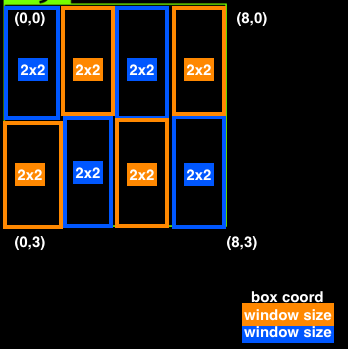


In [36]:
# implement roi pooling from scratch
def ROI_scratch(input, output_size, box):
  # assign the region of interest
  x1,y1,x2,y2 = box 
  intst = input[0, :, y1:(y2+1), x1:(x2+1)]
  # determine size of kernel
  z,x,y = intst.shape
  # print(z,x,y)
  a = (x + 1) // output_size[0] # number of division along x-axis, 2
  b = (y + 1) // output_size[1] # number of division along y-axis, 3
  # define output dimension
  output = np.zeros(shape = (1, z, output_size[0], output_size[1]))
  for z_i in range(z): # loop through all three channels
    intst_i = intst[z_i]
    for i in range(output_size[1]):
      for k in range(output_size[0]):
        b_pr = b * i
        a_pr = a * k
        # print(a_pr, b_pr)
        # print(a, b, i, k)
        if (a_pr + a >= x) and (b_pr + b < y):
          temp = intst_i[(-a):, b_pr:(b_pr + b),]
          #print(temp)
          temp = np.amax(temp)
          output[0, z_i, k, i] = temp
        elif (a_pr + a < x) and (b_pr + b >= y):
          temp = intst_i[a_pr: (a_pr + a), (-b) :]
          #print(temp)
          temp = np.amax(temp)
          output[0, z_i, k, i] = temp
        elif (a_pr + a >= x) and (b_pr + b >= y):
          temp = intst_i[(-a): , (-b) :]
          # print(temp)
          temp = np.amax(temp)
          output[0, z_i, k, i] = temp
        else:
          temp = intst_i[a_pr: (a_pr + a), b_pr:(b_pr + b),] # take max value of each division
          # print(temp)
          temp = np.amax(temp)
          output[0, z_i, k, i] = temp
  return output

In [37]:
output_roi_scratch = ROI_scratch(input_np, [2,3], [0,0,8,3])

In [38]:
# check if the two ouputs are the same (with acceptible level of numerical errors of 1e-4)
(np.absolute(np.subtract(np.round(output_roi_scratch,4), output_roi.detach().numpy())) < 0.0001).all()

True

## 9. Batch Normalization
torch.nn.functional.batch_norm(input, running_mean, running_var,
weight=None, bias=None, training=False, momentum=0.1,
eps=1e-05)

Batch normalization is used to normalize the input in mini-batches to deal with the problem of poorly initialization of neural networks. To implement batch normalization from scratch, the following algorithm is used [3]:

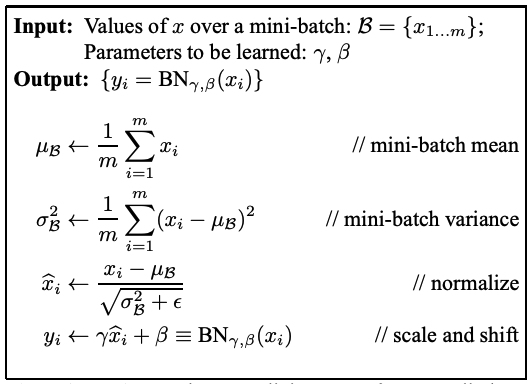

On top of the algorithm, according to Pytorch documentation, momentum is used to correct $\hat{x}$ by $\hat{x} = (1 - momentum) \hat{x} + momentum \times x_t$. However, by comparing the result of the self-implemented function with and without including this formula, it seems that it is not applied if running_mean and running_var are set to `None`, even if momentum is specified to be `0.1`.

In [39]:
# implement batch normalization by pytorch
output_batch = nn.functional.batch_norm(input, running_mean = None, running_var = None, 
                                        weight = None, bias = None, training = True, momentum = 0.1, eps = 1e-05)
output_batch.shape


torch.Size([1, 3, 32, 32])

In [40]:
# implement batch normalization from scratch
def batch_norm_scratch(input, gamma, beta, momentum, eps):
  temp = input[0]
  # loop through 3 channels
  x,y,z = temp.shape
  output = np.zeros(shape = (1,x,y,z)) # specify output size
  for i in range(x):
    temp_i = temp[i]
    mean = temp_i.mean() # mini-batch mean
    var = np.sqrt(temp_i.var() + eps) # mini-batch variance with eps
    for k in range(y):
      for j in range(z):
        x_t = temp_i[k,j]
        x_hat = (x_t - mean) / var # normalize
        #x_hat = (1 - momentum) * x_hat + momentum * x_t # correct x_hat by momentum
        x_hat = gamma * x_hat + beta # element-wise output
        output[0,i,k,j] = x_hat
  return output

In [41]:
output_batch_scratch = batch_norm_scratch(input_np, 1, 0, 0.1, 1e-05)

In [42]:
# check if the two ouputs are the same (with acceptible level of numerical errors of 1e-4)
(np.absolute(np.subtract(np.round(output_batch_scratch,4), output_batch.detach().numpy())) < 0.0001).all()

True

## 10. Cross Entropy
torch.nn.functional.cross_entropy(input, target, weight=None,
size_average=None, ignore_index=-100, reduce=None,
reduction=‘mean')

Cross entropy can be used as loss function when training a classification problem with `C` classes. It measures the performance of a classfication model with output of a probability value between 0 and 1. 

The input of cross entropy function is the predicted probability per class, whereas the target parameter is the actual label. For this assignment, we assume the training problem has a total of 3 classes with 1 object for 2D loss.

In [43]:
torch.manual_seed(127)
# generate input tensor for 1 objecto of 2D loss with 3 classes, each value represent raw score for each class
input_prob = torch.randn(1, 3, 32, 32)
# generate target tensor
target = torch.empty(1, 32, 32, dtype = torch.long).random_(3)
target.shape

torch.Size([1, 32, 32])

In [44]:
input_prob

tensor([[[[-2.7197e-01, -3.9058e-01,  6.1871e-01,  ...,  2.5505e+00,
            1.9551e+00, -1.1305e+00],
          [ 1.0414e+00,  4.6861e-02, -3.8000e-01,  ..., -7.7786e-04,
           -1.5046e+00, -6.9503e-01],
          [ 9.6557e-01,  8.8115e-01, -2.9614e-01,  ..., -1.2833e+00,
            2.3391e+00,  3.9909e-01],
          ...,
          [-5.2284e-01, -3.5270e-01, -4.8768e-01,  ...,  1.0069e+00,
            2.9316e-01,  1.6520e-01],
          [-1.2262e+00,  2.2699e+00,  1.9908e+00,  ...,  7.0747e-01,
           -8.4823e-02,  8.5944e-01],
          [-1.2730e+00,  4.1070e-01,  2.3620e+00,  ..., -1.6267e+00,
           -1.2440e-01,  1.2043e+00]],

         [[-3.2915e-01,  8.9508e-01, -1.0072e+00,  ...,  7.4648e-01,
            1.4715e-01, -1.0429e+00],
          [-6.6423e-01,  7.3124e-01,  1.9920e+00,  ...,  8.6883e-01,
            1.1413e+00, -2.2694e+00],
          [-3.1234e-01,  4.9351e-01, -9.8754e-03,  ...,  9.4232e-01,
           -2.1840e+00,  8.0308e-01],
          ...,
     

In [45]:
# implement cross entropy using pytorch
output_cross = nn.functional.cross_entropy(input_prob, target, weight = None, size_average = None, 
                                           ignore_index = -100, reduce = None, reduction = 'mean')
output_cross.shape

torch.Size([])

In [46]:
# impelement cross entropy from scratch (without weight)
import math
def cross_entropy_scratch(input, target):
  _,x,y,z = input.shape # number of class, height, width
  # calculate loss
  output = np.zeros(shape = (1, y, z))
  for j2 in range(y):
    for k2 in range(z):
      output[0,j2,k2] = - 1* math.log(np.exp(input[0,target[0,j2,k2],j2,k2]) / np.exp(input[0,:,j2,k2]).sum())

  return np.mean(output)


In [47]:
#output_cross_scratch = 
output_cross_scratch = cross_entropy_scratch(input_prob.detach().numpy(), target.detach().numpy())

In [48]:
# check if the two ouputs are the same (with acceptible level of numerical errors of 1e-4)
(np.absolute((np.subtract(np.round(output_cross_scratch,4), output_cross.detach().numpy()))) < 0.0001).all()

True

## 11. MSE Loss
torch.nn.functional.mse_loss(input, target, size_average=None,
reduce=None, reduction='mean')

MSE stands for mean squared error between input and target.

In [49]:
# generate target tensor
torch.manual_seed(2)
target_mse = torch.randn(1, 3, 32, 32, requires_grad = False)
target_mse_np = target_mse.detach().numpy()

In [50]:
# implement mse loss by pytorch
output_mse = nn.functional.mse_loss(input, target_mse, size_average = None, reduce = None, reduction = 'mean')

In [51]:
# implement mse loss from scratch
def mse_scratch(input, target):
  _,x,y,z = input.shape
  # define output to store squared error
  output = np.zeros(shape = (x,y,z))
  for i in range(x):
    for j in range(y):
      for k in range(z):
        temp = (target[0,i,j,k] - input[0,i,j,k]) ** 2
        output[i,j,k] = temp
  return np.mean(output) # return mean squared error

In [52]:
output_mse_scratch = mse_scratch(input_np, target_mse_np)

In [53]:
# check if the two ouputs are the same (with acceptible level of numerical errors of 1e-4)
(np.absolute((np.subtract(np.round(output_mse_scratch,4), output_mse.detach().numpy()))) < 0.0001).all()

True

# Export outputs

Print all outputs from pytorch as `torch_out`, and print all outpus from self-implemented functions as `my_out`

In [54]:
# write torch_out
np.set_printoptions(threshold=np.inf)
with open('/content/drive/MyDrive/Colab Notebooks/BS6207/Assignment3/torch_out.dat',"w") as file:
  file.write('\nMaxPool2d\n')
  file.write(np.array2string(output_max.detach().numpy(), precision = 4, separator = ','))
  file.write('\nAvgPool2d\n')
  file.write(np.array2string(output_avg.detach().numpy(), precision = 4, separator = ','))
  file.write('\nConv2d_1\n')
  file.write(np.array2string(output_conv1.detach().numpy(), precision = 4, separator = ','))
  file.write('\nConv2d_2\n')
  file.write(np.array2string(output_conv2.detach().numpy(), precision = 4, separator = ','))
  file.write('\nConvTranspose2d\n')
  file.write(np.array2string(output_convtrans.detach().numpy(), precision = 4, separator = ','))
  file.write('\nFlatten\n')
  file.write(np.array2string(output_flat.detach().numpy(), precision = 4, separator = ','))
  file.write('\nSigmoid\n')
  file.write(np.array2string(output_sig.detach().numpy(), precision = 4, separator = ','))
  file.write('\nROI_pool\n')
  file.write(np.array2string(output_roi.detach().numpy(), precision = 4, separator = ','))
  file.write('\nBatch_normalization\n')
  file.write(np.array2string(output_batch.detach().numpy(), precision = 4, separator = ','))
  file.write('\nCross_Entropy\n')
  file.write(np.array2string(output_cross.detach().numpy(), precision = 4, separator = ','))
  file.write('\nMSE_Loss\n')
  file.write(np.array2string(output_mse.detach().numpy(), precision = 4, separator = ','))

In [55]:
# write my_out
np.set_printoptions(threshold=np.inf)

with open('/content/drive/MyDrive/Colab Notebooks/BS6207/Assignment3/my_out.dat',"w") as file:
  file.write('\nMaxPool2d\n')
  file.write(np.array2string(output_max_scratch, precision = 4, separator = ','))
  file.write('\nAvgPool2d\n')
  file.write(np.array2string(output_avg_scratch, precision = 4, separator = ','))
  file.write('\nConv2d_1\n')
  file.write(np.array2string(output_conv1_scratch, precision = 4, separator = ','))
  file.write('\nConv2d_2\n')
  file.write(np.array2string(output_conv2_scratch, precision = 4, separator = ','))
  file.write('\nConvTranspose2d\n')
  file.write(np.array2string(output_convtrans_scratch, precision = 4, separator = ','))
  file.write('\nFlatten\n')
  file.write(np.array2string(output_flat_scratch, precision = 4, separator = ','))
  file.write('\nSigmoid\n')
  file.write(np.array2string(output_sig_scratch, precision = 4, separator = ','))
  file.write('\nROI_pool\n')
  file.write(np.array2string(output_roi_scratch, precision = 4, separator = ','))
  file.write('\nBatch_normalization\n')
  file.write(np.array2string(output_batch_scratch, precision = 4, separator = ','))
  file.write('\nCross_Entropy\n')
  file.write(np.array2string(output_cross_scratch, precision = 4, separator = ','))
  file.write('\nMSE_Loss\n')
  file.write(np.array2string(output_mse_scratch, precision = 4, separator = ','))

## _References_

[1] What is Transposed Convolutional Layer? https://towardsdatascience.com/what-is-transposed-convolutional-layer-40e5e6e31c11

[2] Transposed Convolutions explained with... MS Excel! https://medium.com/apache-mxnet/transposed-convolutions-explained-with-ms-excel-52d13030c7e8

[3] Ioffe, S. & Szegedy, C.. (2015). Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift. Proceedings of the 32nd International Conference on Machine Learning, in Proceedings of Machine Learning Research 37:448-456 Available from http://proceedings.mlr.press/v37/ioffe15.html .